# Used Packages

In [1]:
import os
import glob
import gc

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from scipy.spatial.transform import Rotation as R

from utils.MovingAverager import *
from collections import defaultdict
from torchinfo import summary

from datetime import datetime
from random import randint

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Global Variable

In [2]:
rotation = False
num_of_axis = 3

datapoint_per_second = 20
duration = 2
seq_len = 10

In [3]:
validation_traj = np.load(f'./npys/all_user_match_data.npy', allow_pickle=True)

In [4]:
parent_path = '/root/Calibration/R403/model'
tim = datetime.now().strftime("%b%d%Y")
path = os.path.join(parent_path, tim+'_Calibrate')
try:
    os.makedirs(path, exist_ok=True)
    print("Directory '%s' created successfully" % path)
except OSError as error:
    print("Directory '%s' can not be created")

Directory '/root/Calibration/R403/model/Jun112024_Calibrate' created successfully


In [5]:
class KalmanFilter:
    def __init__(self, dt, gyro_noise_std, acc_noise_std):
        self.dt = dt
        self.gyro_noise_std = gyro_noise_std
        self.acc_noise_std = acc_noise_std
        
        self.Q = np.eye(3) * gyro_noise_std**2
        self.R = np.eye(3) * acc_noise_std**2
        
        self.P = np.eye(3)
        self.x = np.zeros(3)
    
    def predict(self, gyro_measurements):
        F = np.eye(3) + self.dt * self.skew_symmetric(gyro_measurements)
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + self.Q
    
    def update(self, acc_measurements, Rk):
        z = acc_measurements
        H = np.eye(3)
        y = z - H @ self.x
        S = H @ self.P @ H.T + Rk
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(3) - K @ H) @ self.P
    
    def skew_symmetric(self, v):
        return np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])

class AttitudeEstimator:
    def __init__(self, dt, gyro_noise_std, acc_noise_std, method='STF'):
        self.kf = KalmanFilter(dt, gyro_noise_std, acc_noise_std)
        self.method = method
    
    def estimate_attitude(self, gyro_measurements, acc_measurements):
        self.kf.predict(gyro_measurements)
        Rk = self.adaptive_measurement_noise_covariance(acc_measurements)
        self.kf.update(acc_measurements, Rk)
        return self.kf.x
    
    def adaptive_measurement_noise_covariance(self, acc_measurements):
        if self.method == 'STF':
            return self.adaptive_measurement_noise_covariance_stf(acc_measurements)
        elif self.method == 'MTF':
            return self.adaptive_measurement_noise_covariance_mtf(acc_measurements)
        else:
            raise ValueError("Method must be 'STF' or 'MTF'")
    
    def adaptive_measurement_noise_covariance_stf(self, acc_measurements):
        innovation = acc_measurements - self.kf.x
        St = np.sum(innovation**2) / 3 - np.trace(self.kf.R) / 3
        St = max(0, St)
        return np.eye(3) * St
    
    def adaptive_measurement_noise_covariance_mtf(self, acc_measurements):
        innovation = acc_measurements - self.kf.x
        St = np.zeros(3)
        for i in range(3):
            St[i] = max(0, innovation[i]**2 - self.kf.R[i, i])
        return np.diag(St)
    
    def get_roll_pitch(self):
        roll = np.arctan2(self.kf.x[1], self.kf.x[2])
        pitch = np.arctan2(-self.kf.x[0], np.sqrt(self.kf.x[1]**2 + self.kf.x[2]**2))
        return roll, pitch

class RotationMatrixCalculator:
    @staticmethod
    def from_roll_pitch(roll, pitch):
        R_x = np.array([
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll), np.cos(roll)]
        ])
        
        R_y = np.array([
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)]
        ])
        
        R = R_x @ R_y
        return R

estimator = AttitudeEstimator(0.05, 0.01, 0.1, 'MTF')    

def process_sequence(gyro_data, acc_data, acc_lin_data, mag_data):
    rotation_matrices = []
    rotated_acc_data = []
    rotated_acc_lin_data = []
    rotated_mag_data = []
    rotated_gyro_data = []
    
    for gyro_measurements, acc_measurements, acc_lin_measurements, mag_measurements in zip(gyro_data, acc_data, acc_lin_data, mag_data):
        estimator.estimate_attitude(np.array(gyro_measurements), np.array(acc_measurements))
        roll, pitch = estimator.get_roll_pitch()
        R = RotationMatrixCalculator.from_roll_pitch(roll, pitch)
        
        rotated_acc = R @ np.array(acc_measurements)
        rotated_gyro = R @ np.array(gyro_measurements)
        rotated_acc_lin = R @ np.array(acc_lin_measurements)
        rotated_mag = R @ np.array(mag_measurements)
        
        rotation_matrices.append(R)
        rotated_acc_data.append(rotated_acc)
        rotated_acc_lin_data.append(rotated_acc_lin)
        rotated_gyro_data.append(rotated_gyro)
        rotated_mag_data.append(rotated_mag)
    
    return np.concatenate((np.array(rotated_acc_data), np.array(rotated_acc_lin_data), np.array(rotated_gyro_data)), axis=-1), np.array(rotated_mag_data),

In [6]:
def get_data(validation_traj, num_of_axis, rotation):    
    posture_data = defaultdict(list)

    valid_data = validation_traj.item()
    for user_name in valid_data.keys():
        for path_name in valid_data[user_name].keys():
            for posture_name in valid_data[user_name][path_name].keys():
                data = valid_data[user_name][path_name][posture_name]

                if posture_name == 'ref_mag':
                    if num_of_axis == 2:
                        posture_data[posture_name].append(data[:, [0, 1, 6, 7, 5]])
                    else:
                        posture_data[posture_name].append(data[:, [0, 1, 2, 3, 4, 6, 7, 5]])
                    continue

                pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
                imu = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11]]
#                 imu[:, 3:6] *= 10
#                 imu[:, 6:9] = imu[:, 6:9] * 18 / np.pi
                mag = data[:, [12, 13, 14]]

                if rotation:
                    imu, mag = process_sequence(imu[:, 6:9], imu[:, 0:3], imu[:, 3:6], mag)
                if num_of_axis == 2: 
                    mag = np.column_stack((np.sqrt(np.sum(mag[:, :2]**2, axis=1)), mag[:, 2]))
#                 imu = imu[:, [0, 3, 6, 1, 4, 7, 2, 5, 8]]
                pos_mag = np.concatenate((pos, imu, mag, data[:, [15]]), axis=-1)            
                posture_data[posture_name].append(pos_mag)
    
    return posture_data

In [7]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [8]:
datapoint_per_second = 20
duration = 2
seq_len = 20

# Data Loader

In [40]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        assert (source_data.shape[0] == source_label.shape[0] == target_data.shape[0] == target_label.shape[0]), f'{source_data.shape}, {source_label.shape}, {target_data.shape}, {target_label.shape}'
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]
    
    def normalize(self):
        s_mean = self.source_data.mean(dim=0, keepdim=True)
        s_std = self.source_data.std(dim=0, keepdim=True)
        
        self.source_data  = (self.source_data - s_mean / s_std)
        t_mean = self.target_data.mean(dim=0, keepdim=True)
        t_std = self.target_data.std(dim=0, keepdim=True)
        
        self.target_data  = (self.target_data - t_mean / t_std)

In [50]:
def for_dataloaders(traj, gt='target'):
    t_data = 0
    t_label = 0
    t_target_data = 0
    v_data = 0
    v_label = 0
    v_target_data = 0
    label = 1
    label_dict = {}
    flag = False
    for key, value in traj.items():
        split = len(value) * 9 // 10
        tmp1, tmp2 = value[:split], value[split:]
        if key != gt: 
            t_data = np.concatenate((t_data, tmp1)) if flag else tmp1
            t_label = np.concatenate((t_label, np.full((tmp1.shape[0], ), label))) if flag else np.full((tmp1.shape[0], ), label)
            v_data = np.concatenate((v_data, tmp2)) if flag else tmp2
            v_label = np.concatenate((v_label, np.full((tmp2.shape[0], ), label))) if flag else np.full((tmp2.shape[0], ), label)
            flag = True
            label_dict[label] = key
            label += 1
        else:
            l = len(traj.values()) - 1
            t_target_data = np.tile(tmp1, (l, 1, 1))
            v_target_data = np.tile(tmp2, (l, 1, 1))
            label_dict[0] = key
    
    train_dataset = PairDataset(
                        source_data = torch.tensor(t_data, dtype=torch.float),
                        source_label = t_label,
                        target_data = torch.tensor(t_target_data, dtype=torch.float),
                        target_label = np.zeros((len(t_target_data), ))
                    )
    
    valid_dataset = PairDataset(
                        source_data = torch.tensor(v_data, dtype=torch.float),
                        source_label = v_label,
                        target_data = torch.tensor(v_target_data, dtype=torch.float),
                        target_label = np.zeros((len(v_target_data), ))
                    )

    print(label_dict)
    return label_dict, train_dataset, valid_dataset

# Model Declaration

In [11]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]

        # calculate the loss as the mean squared error of the derivative
        loss = mae_loss(d_source, d_target)

        return loss

In [12]:
def generator_loss(z_imu, target_imu):
    acc_loss = mse_loss(z_imu[:, :, :3], target_imu[:, :, :3])
    lin_loss = mse_loss(z_imu[:, :, 3:6], target_imu[:, :, 3:6])
    gyr_loss = mse_loss(z_imu[:, :, 6:], target_imu[:, :, 6:])
    total_loss = acc_loss + lin_loss + gyr_loss
    
    return total_loss, (acc_loss, lin_loss, gyr_loss)

In [46]:
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [14]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    return mask.to(device)

In [41]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        self.mag_axis = num_of_axis
        
        self.acc_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.ELU(),
            PositionalEncoding(16, 0.1)
        )
        
        self.lin_acc_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.ELU(),
            PositionalEncoding(16, 0.1)
        )
        
        self.gyro_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.ELU(),
            PositionalEncoding(16, 0.1)
        )
        self.pos_encoder = PositionalEncoding(16, 0.1)
        
        self.acc_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        self.lin_acc_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        self.gyro_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        
        self.fusing = nn.Sequential(
            nn.Linear(48, 48),
            nn.ELU(),
            nn.Linear(48, 16),
            nn.ELU(),
        )
        
        self.acc_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        self.lin_acc_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        self.gyro_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        
        self.acc_nn = nn.Linear(16, 3)
        self.lin_acc_nn = nn.Linear(16, 3)
        self.gyro_nn = nn.Linear(16, 3)
        
    def forward(self, source_imu, target_imu=None):
        bs, seq_len, _ = source_imu.size()

        ### step 1
        h_acc = self.acc_layer(source_imu[:, :, :3])
        h_lin = self.lin_acc_layer(source_imu[:, :, 3:6])
        h_gyr = self.gyro_layer(source_imu[:, :, 6:])

        ### step 2
        m_acc = self.acc_encoder(h_acc)
        m_lin = self.lin_acc_encoder(h_lin)
        m_gyr = self.gyro_encoder(h_gyr)
        
#         m_fus = self.fusing(torch.cat((m_acc, m_lin, m_gyr), dim=2))

        if target_imu is not None:
            # If target_imu is provided, use it directly
            t_acc = self.acc_layer(torch.cat((torch.zeros(bs, 1, 3).to(source_imu.device), target_imu[:, :, :3]), dim=1))
            t_lin = self.lin_acc_layer(torch.cat((torch.zeros(bs, 1, 3).to(source_imu.device), target_imu[:, :, 3:6]), dim=1))
            t_gyr = self.gyro_layer(torch.cat((torch.zeros(bs, 1, 3).to(source_imu.device), target_imu[:, :, 6:]), dim=1))

            p_acc = self.acc_decoder(t_acc, m_acc, tgt_mask=get_tgt_mask(seq_len+1))
            p_lin = self.lin_acc_decoder(t_lin, m_lin, tgt_mask=get_tgt_mask(seq_len+1))
            p_gyr = self.gyro_decoder(t_gyr, m_gyr, tgt_mask=get_tgt_mask(seq_len+1))

            p_acc = self.acc_nn(p_acc)
            p_lin = self.lin_acc_nn(p_lin)
            p_gyr = self.gyro_nn(p_gyr)

            p_imu = torch.cat((p_acc[:, 1:, :], p_lin[:, 1:, :], p_gyr[:, 1:, :]), dim=2)
        else:
            # If target_imu is not provided, iteratively generate it
            # Initialize the first target with zeros
            tgt_acc = torch.zeros(bs, 1, 3).to(source_imu.device)
            tgt_lin = torch.zeros(bs, 1, 3).to(source_imu.device)
            tgt_gyr = torch.zeros(bs, 1, 3).to(source_imu.device)

            p_acc = torch.zeros(bs, seq_len, 3).to(source_imu.device)
            p_lin = torch.zeros(bs, seq_len, 3).to(source_imu.device)
            p_gyr = torch.zeros(bs, seq_len, 3).to(source_imu.device)

            for i in range(seq_len):
                # Generate the next step prediction
                t_acc = self.acc_layer(tgt_acc)
                t_lin = self.lin_acc_layer(tgt_lin)
                t_gyr = self.gyro_layer(tgt_gyr)

                p_acc_step = self.acc_decoder(t_acc, m_acc, tgt_mask=get_tgt_mask(i+1))
                p_lin_step = self.lin_acc_decoder(t_lin, m_lin, tgt_mask=get_tgt_mask(i+1))
                p_gyr_step = self.gyro_decoder(t_gyr, m_gyr, tgt_mask=get_tgt_mask(i+1))

                p_acc_step = self.acc_nn(p_acc_step)
                p_lin_step = self.lin_acc_nn(p_lin_step)
                p_gyr_step = self.gyro_nn(p_gyr_step)

                # Update the predictions for the current step
                p_acc[:, i, :] = p_acc_step[:, -1, :]
                p_lin[:, i, :] = p_lin_step[:, -1, :]
                p_gyr[:, i, :] = p_gyr_step[:, -1, :]

                # Update the target for the next iteration
                tgt_acc = torch.cat((tgt_acc, p_acc[:, i:i+1, :]), dim=1)
                tgt_lin = torch.cat((tgt_lin, p_lin[:, i:i+1, :]), dim=1)
                tgt_gyr = torch.cat((tgt_gyr, p_gyr[:, i:i+1, :]), dim=1)

            p_imu = torch.cat((p_acc, p_lin, p_gyr), dim=2)

        return p_imu

In [16]:
def plot_result(result):
    idx = ['acc', 'lin_acc', 'gyro']
    pred_imu = result[0].reshape(-1, 9)
    targ_imu = result[1].reshape(-1, 9)
    x = np.arange(len(pred_imu))
    
    fig = plt.figure(figsize=(15, 10))
    
    for i in range(3):
        start = i * 3
        loss = torch.sqrt(mse_loss(torch.tensor(pred_imu[:, start:start+3]), torch.tensor(targ_imu[:, start:start+3]))).item()
        
        ax = plt.subplot(3, 1, i+1)
        for pm, tm, caxis, color in zip(pred_imu[:, start:start+3].T, targ_imu[:, start:start+3].T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
            plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
            plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
        ax.title.set_text(f'{idx[i]} Loss: {loss:.2f}')

    plt.legend()
    plt.show()

In [53]:
def train(dataloader, draw=False, epoch_ratio=1):
    model.train()

    g_losses = []
    acc_losses = []
    lin_losses = []
    gyr_losses = []
    pred_seqs = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 2:11] + torch.randn_like(source_data[:, :, 2:11]) * 0.25
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, 2:11]

        # generate mag
        p_imu = model(source_imu, target_imu)
        
        # generator loss
        gen_loss, (acc_loss, lin_loss, gyr_loss) = generator_loss(p_imu, target_imu)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        acc_losses.append(acc_loss.item())
        lin_losses.append(lin_loss.item())
        gyr_losses.append(gyr_loss.item())
    
    if draw:
        rs = [p_imu[0].detach().cpu().numpy(), target_imu[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(acc_losses), np.mean(lin_losses), np.mean(gyr_losses)

In [18]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    acc_losses = []
    lin_losses = []
    gyr_losses = []
    pred_seqs = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 2:11]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, 2:11]

            # generate mag
            p_imu = model(source_imu)

            # generator loss
            gen_loss, (acc_loss, lin_loss, gyr_loss) = generator_loss(p_imu, target_imu)
            
            # record loss
            g_losses.append(gen_loss.item())
            acc_losses.append(acc_loss.item())
            lin_losses.append(lin_loss.item())
            gyr_losses.append(gyr_loss.item())
    
    if draw:
        rs = [p_imu[0].detach().cpu().numpy(), target_imu[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(acc_losses), np.mean(lin_losses), np.mean(gyr_losses)

In [31]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 2:11]

            target_data = target_data.to(device)
            target_pos = target_data[:, :, :2]
            target_imu = target_data[:, :, 2:11]

            # generate mag
            p_imu = model(source_imu)
            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            p_imu = p_imu.detach().cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            target_imu = target_imu.detach().cpu().numpy()
            
            results.extend(zip(p_imu, target_imu, source_label))
            
            acc_diff = np.power(p_imu[:, :, :3] - target_imu[:, :, :3], 2).mean(axis=1)
            lin_diff = np.power(p_imu[:, :, 3:6] - target_imu[:, :, 3:6], 2).mean(axis=1)
            gyr_diff = np.power(p_imu[:, :, 6:] - target_imu[:, :, 6:], 2).mean(axis=1)
            
            class_results.extend(zip(acc_diff, lin_diff, gyr_diff))
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [36]:
def show_result(model, dataloader):
    idx = ['acc', 'lin_acc', 'gyro']
    results, cres, clabel = output_eval(model, dataloader)
    print(results.shape, cres.shape, clabel.shape)
    for i in range(3):
        print(f'{idx[i]+" loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy, dz = cres[clabel == class_label][:, i].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
        dx, dy, dz = cres[:, i].mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

    for rs in results[::500]:
        plot_result(rs)

# Experiment 1
rotation = False
num_of_axis = 2Different final ground truth (最終姿態)

In [51]:
num_of_axis, rotation, gt = 3, False, 'target'

posture_data = get_data(validation_traj, num_of_axis, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
prep_valid_traj['dummy']        = split_traj(posture_data['target'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

{1: 'front_pocket', 2: 'dummy', 3: 'pocket', 4: 'swing', 0: 'target'}


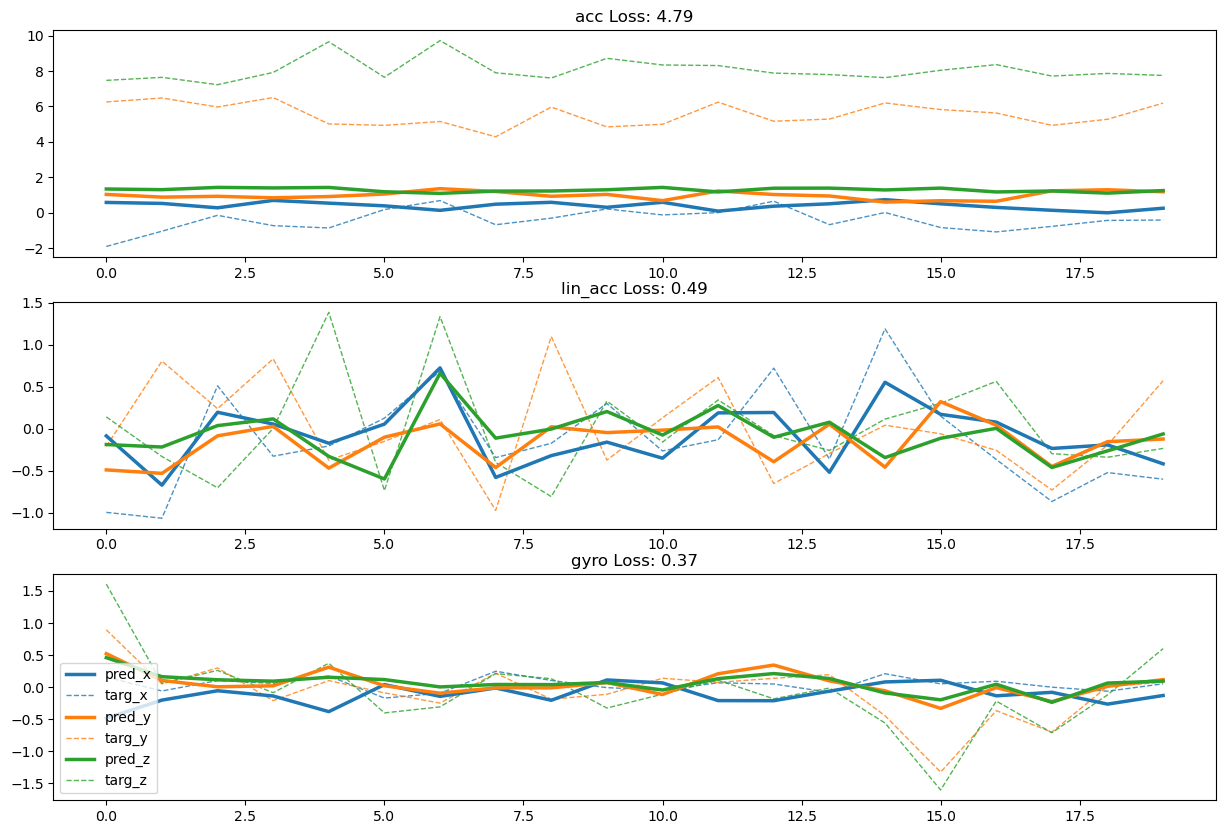

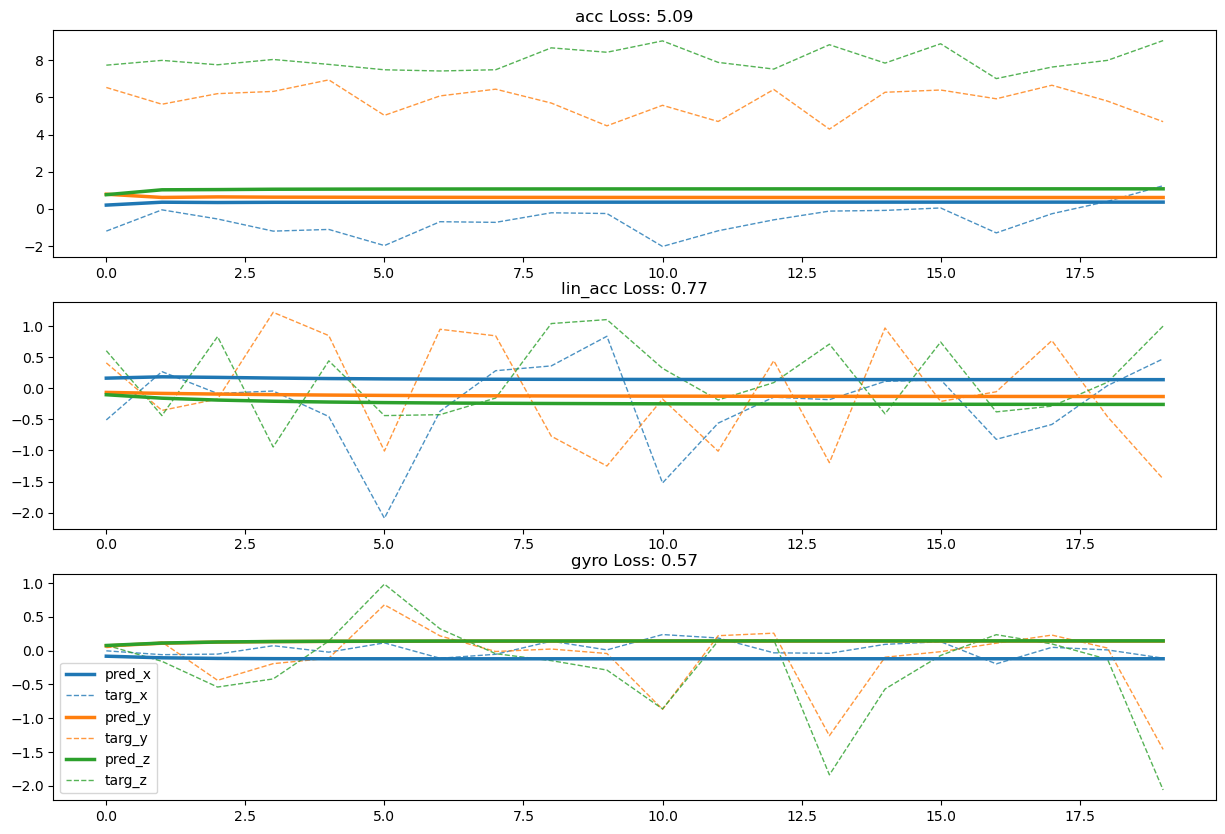

00000: train loss:  26.789, acc loss: 26.109, lin loss:  0.509, gyr loss:  0.171
       valid loss:  25.216, acc loss: 24.500, lin loss:  0.523, gyr loss:  0.193
00100: train loss:   0.499, acc loss:  0.473, lin loss:  0.019, gyr loss:  0.008
       valid loss:   2.247, acc loss:  1.534, lin loss:  0.531, gyr loss:  0.183
00200: train loss:   0.169, acc loss:  0.156, lin loss:  0.010, gyr loss:  0.004
       valid loss:   2.039, acc loss:  1.363, lin loss:  0.479, gyr loss:  0.196
00300: train loss:   0.095, acc loss:  0.086, lin loss:  0.007, gyr loss:  0.002
       valid loss:   2.006, acc loss:  1.353, lin loss:  0.470, gyr loss:  0.183
00400: train loss:   0.067, acc loss:  0.059, lin loss:  0.005, gyr loss:  0.002
       valid loss:   1.817, acc loss:  1.164, lin loss:  0.472, gyr loss:  0.181
00500: train loss:   0.050, acc loss:  0.044, lin loss:  0.005, gyr loss:  0.001
       valid loss:   1.793, acc loss:  1.133, lin loss:  0.477, gyr loss:  0.182
00600: train loss:   0.040, 

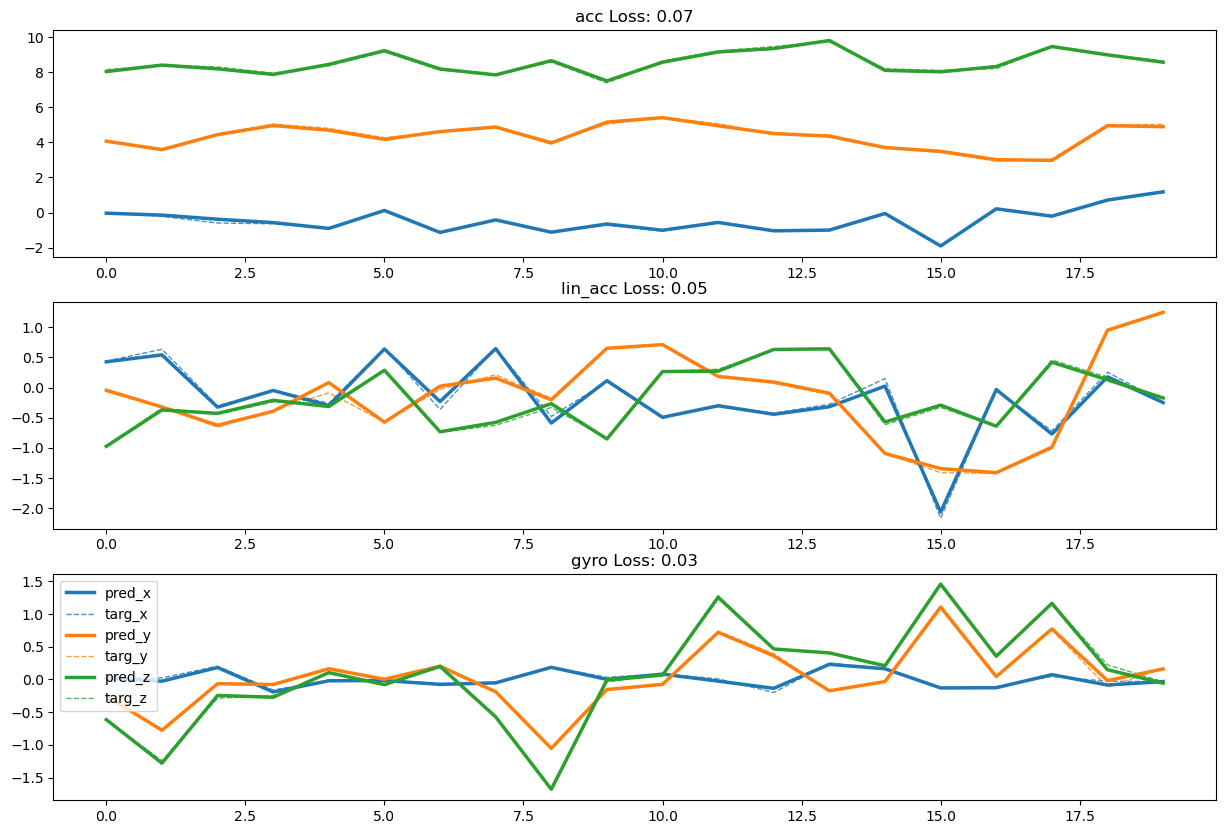

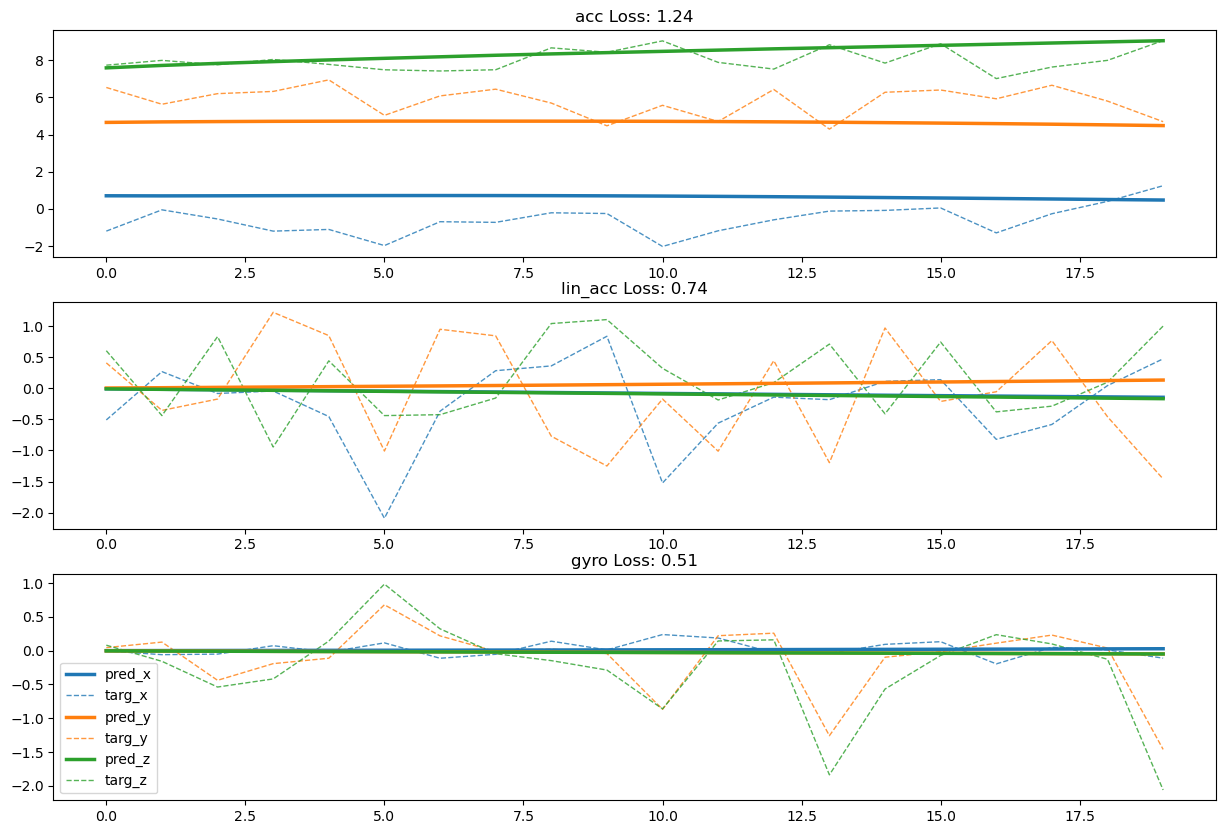

02000: train loss:   0.012, acc loss:  0.010, lin loss:  0.002, gyr loss:  0.001
       valid loss:   2.076, acc loss:  1.408, lin loss:  0.487, gyr loss:  0.181
02100: train loss:   0.011, acc loss:  0.009, lin loss:  0.002, gyr loss:  0.000
       valid loss:   1.911, acc loss:  1.257, lin loss:  0.474, gyr loss:  0.180
02200: train loss:   0.011, acc loss:  0.009, lin loss:  0.002, gyr loss:  0.000
       valid loss:   1.908, acc loss:  1.241, lin loss:  0.486, gyr loss:  0.181
02300: train loss:   0.011, acc loss:  0.009, lin loss:  0.002, gyr loss:  0.000
       valid loss:   1.909, acc loss:  1.258, lin loss:  0.467, gyr loss:  0.184
02400: train loss:   0.011, acc loss:  0.009, lin loss:  0.002, gyr loss:  0.000
       valid loss:   1.940, acc loss:  1.283, lin loss:  0.475, gyr loss:  0.181
02500: train loss:   0.010, acc loss:  0.008, lin loss:  0.002, gyr loss:  0.000
       valid loss:   1.961, acc loss:  1.300, lin loss:  0.481, gyr loss:  0.179
02600: train loss:   0.009, 

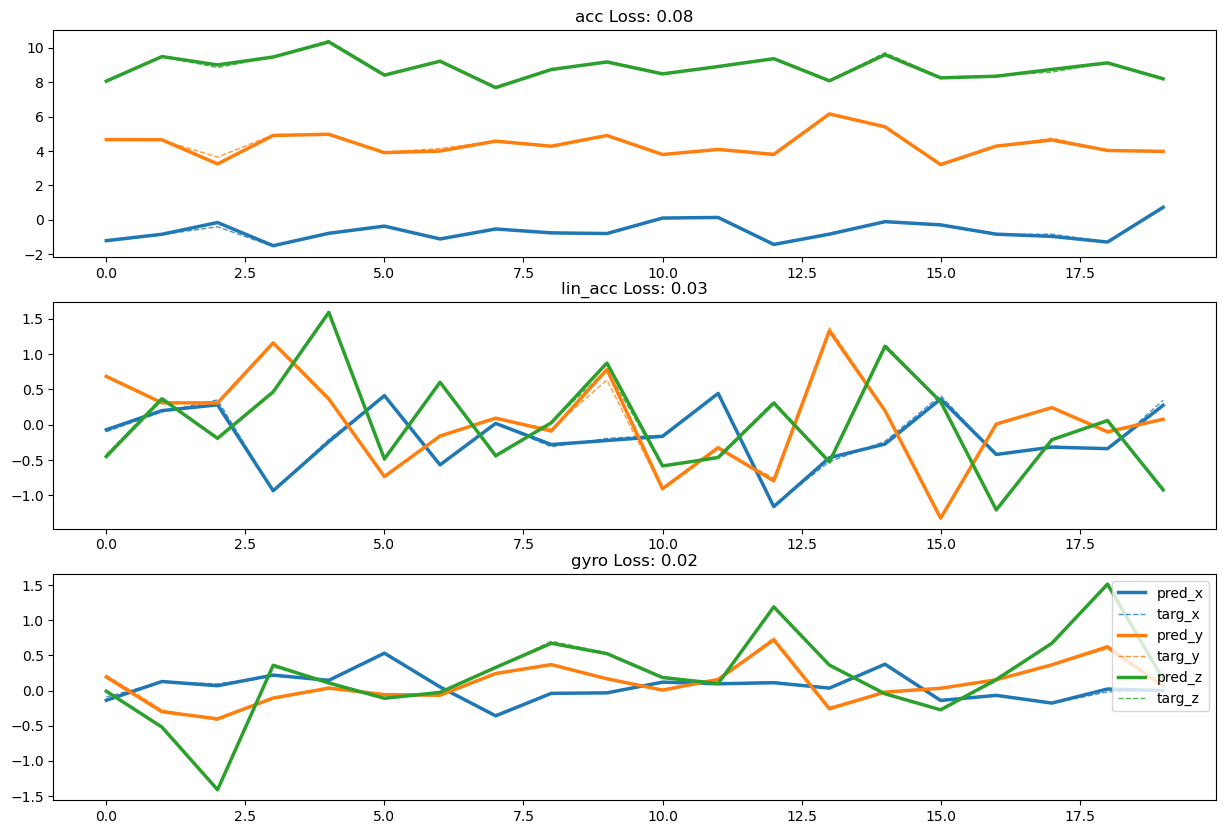

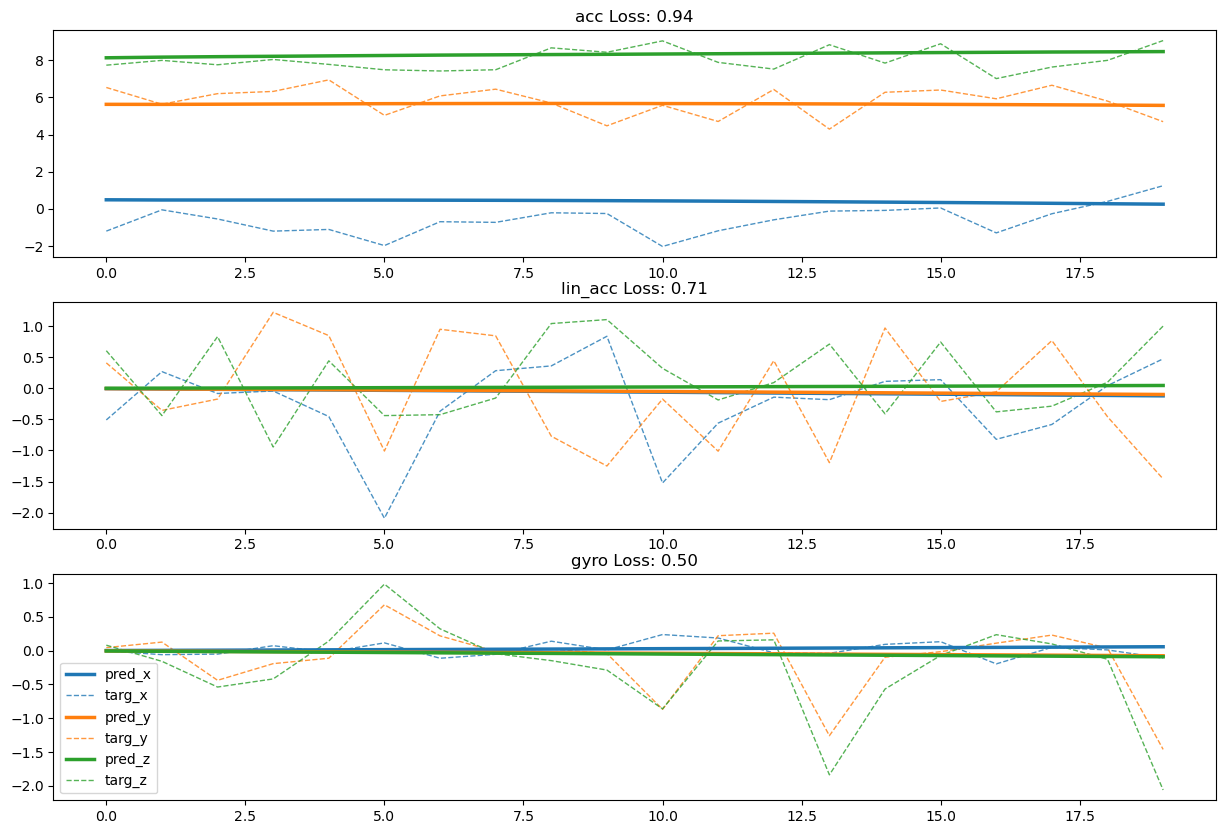

04000: train loss:   0.007, acc loss:  0.005, lin loss:  0.001, gyr loss:  0.000
       valid loss:   1.822, acc loss:  1.176, lin loss:  0.465, gyr loss:  0.180
04100: train loss:   0.007, acc loss:  0.005, lin loss:  0.001, gyr loss:  0.000
       valid loss:   1.780, acc loss:  1.127, lin loss:  0.471, gyr loss:  0.182
04200: train loss:   0.007, acc loss:  0.005, lin loss:  0.001, gyr loss:  0.000
       valid loss:   1.793, acc loss:  1.140, lin loss:  0.466, gyr loss:  0.187
04300: train loss:   0.007, acc loss:  0.005, lin loss:  0.001, gyr loss:  0.000
       valid loss:   1.795, acc loss:  1.144, lin loss:  0.468, gyr loss:  0.183
04400: train loss:   0.007, acc loss:  0.005, lin loss:  0.001, gyr loss:  0.000
       valid loss:   1.782, acc loss:  1.132, lin loss:  0.467, gyr loss:  0.184
04500: train loss:   0.006, acc loss:  0.005, lin loss:  0.001, gyr loss:  0.000
       valid loss:   1.789, acc loss:  1.137, lin loss:  0.468, gyr loss:  0.184
04600: train loss:   0.006, 

In [ ]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    draw = ((epoch) % 2000 == 0)
    
    train_loss, train_acc_loss, train_lin_loss, train_gyr_loss = train(train_loader, draw, epoch / EPOCH)
    
    if epoch % 100 == 0:
        valid_loss, valid_acc_loss, valid_lin_loss, valid_gyr_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, acc loss: {train_acc_loss:>6.3f}, lin loss: {train_lin_loss:>6.3f}, gyr loss: {train_gyr_loss:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>7.3f}, acc loss: {valid_acc_loss:>6.3f}, lin loss: {valid_lin_loss:>6.3f}, gyr loss: {valid_gyr_loss:>6.3f}')

In [ ]:
show_result(model, train_loader)

In [ ]:
show_result(model, valid_loader)

In [38]:
torch.save(model, f'{path}/{gt}_{num_of_axis}_{rotation}_rework.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

NameError: name 'optimizer' is not defined

In [ ]:
num_of_axis, rotation, gt = 3, True, 'target'

posture_data = get_data(validation_traj, num_of_axis, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
# prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
acc_para = list(model.acc_layer.parameters()) + list(model.acc_encoder.parameters()) + list(model.acc_decoder.parameters()) + list(model.acc_nn.parameters())
lin_para = list(model.lin_acc_layer.parameters()) + list(model.lin_acc_encoder.parameters()) + list(model.lin_acc_decoder.parameters()) + list(model.lin_acc_nn.parameters())
gyr_para = list(model.gyro_layer.parameters()) + list(model.gyro_encoder.parameters()) + list(model.gyro_decoder.parameters()) + list(model.gyro_nn.parameters())

optimizer_acc = torch.optim.Adam(acc_para, lr=0.0001)
optimizer_lin = torch.optim.Adam(lin_para, lr=0.0001)
optimizer_gyr = torch.optim.Adam(gyr_para, lr=0.0001)

In [ ]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    draw = ((epoch) % 2000 == 0)
    
    train_loss, train_acc_loss, train_lin_loss, train_gyr_loss = train(train_loader, draw, epoch / EPOCH)
    
    if epoch % 100 == 0:
        valid_loss, valid_acc_loss, valid_lin_loss, valid_gyr_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, acc loss: {train_acc_loss:>6.3f}, lin loss: {train_lin_loss:>6.3f}, gyr loss: {train_gyr_loss:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>7.3f}, acc loss: {valid_acc_loss:>6.3f}, lin loss: {valid_lin_loss:>6.3f}, gyr loss: {valid_gyr_loss:>6.3f}')

In [ ]:
show_result(model, train_loader)

In [ ]:
show_result(model, valid_loader)

In [ ]:
torch.save(model, f'{path}/{gt}_{num_of_axis}_{rotation}_rework.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

In [ ]:
num_of_axis, rotation, gt = 3, False, 'horizontal'

posture_data = get_data(validation_traj, num_of_axis, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
imu_layer_params = list(model.imu_layer.parameters())
encoder_params = list(model.encoder.parameters())
nn_params = list(model.nn.parameters())
initial_params = imu_layer_params + encoder_params + nn_params
optimizer = torch.optim.Adam(initial_params, lr=0.0001)

In [ ]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    if epoch == 1000: optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    draw = ((epoch) % 20000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw, epoch / EPOCH)
    
    if (epoch) % 100 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>7.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

In [ ]:
show_result(model, train_loader)

In [ ]:
show_result(model, valid_loader)

In [ ]:
torch.save(model, f'{path}/{gt}_{num_of_axis}_{rotation}_rework.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()